# Exploring "HLSS30" using tensorlakehouse

### Data description
* Collection/dataset:"HLSS30"
* Data Source: GeoTiff stored on Cloud Object Store (COS) 

### Functionalities
* tensorlakehouse (openEO) functionalities:
    - describe collection
    - load collection

### Setup

1. Create a python virtualenv (python 3.11.7 is the recommended version). 
2. Clone the repository:
```
git clone https://github.com/IBM/tensorlakehouse-openeo-driver.git
``` 

3. Go to
```
cd tensorlakehouse-openeo-driver/tutorials
```

4. Install dependencies:
```
pip install -r tutorial_requirements.txt
```

5. Run jupyter notebook or jupyter lab
```
jupyter lab .
```


In [1]:
import rioxarray as rxr
import os
os.environ['USE_PYGEOS'] = '0'
import matplotlib.pyplot as plt
from pathlib import Path
# openeo is a client-side implementation that allows users to query OpenEO service
import openeo
# pystac_client is a client-side implementation that allows users to query STAC service
from pystac_client import Client
# OpenEO service URL
import os
from dotenv import load_dotenv
import pandas as pd
import xarray as xr


Set URL and credentials of the OpenEO service

In [2]:
# username and password are hardcoded in the backend as an example for testing
load_dotenv()
OPENEO_URL="https://tensorlakehouse-openeo-driver-geospatial-be-staging.apps.fmaas-backend.fmaas.res.ibm.com"
username = os.environ["OPENEO_USERNAME"]
password = os.environ["OPENEO_PASSWORD"]

# authenticate using basic auth
openeo_conn = openeo.connect(OPENEO_URL).authenticate_basic(username, password)


In [3]:
# set time interval
start ='2020-07-01T19:13:57Z'
end = '2020-07-01T20:13:57Z'
time_range = f"{start}/{end}"

# set bounding box
west = -123.0
east = -122.9
south = 38.0
north = 38.1


collection_id = "HLSS30"
spatial_extent={
        'west' : west,
        'south' : south,
        'east' : east,
        'north' : north
    }

temporal_extent=[start, end]
# create data dir to save files
data_dir = Path("test_data")
if not data_dir.exists():
    data_dir.mkdir()

In [4]:
openeo_conn.describe_collection(collection_id)

{'cube:dimensions': {'bands': {'type': 'bands',
   'values': ['B01', 'B02', 'B03', 'B04', 'B8A', 'B11', 'B12', 'Fmask']},
  'time': {'extent': ['2020-01-01T00:00:00+00:00',
    '2022-01-01T00:00:00+00:00'],
   'type': 'temporal'},
  'x': {'axis': 'x', 'extent': [399960.0, 509760.0], 'type': 'spatial'},
  'y': {'axis': 'y', 'extent': [4300020.0, 4190220.0], 'type': 'spatial'}},
 'deprecated': False,
 'description': 'HLSS30',
 'extent': {'spatial': {'bbox': [[-180.0, -90.0, 180.0, 90.0]]},
  'temporal': {'interval': [['2020-01-01T00:00:00Z',
     '2022-01-01T00:00:00Z']]}},
 'id': 'HLSS30',
 'keywords': [],
 'license': 'Unknown',
 'links': [{'href': 'http://stac-fastapi-pgstac.geospatial-be-staging.svc.cluster.local:8080/collections/HLSS30/items',
   'rel': 'items',
   'type': 'application/geo+json'},
  {'href': 'http://stac-fastapi-pgstac.geospatial-be-staging.svc.cluster.local:8080/',
   'rel': 'parent',
   'type': 'application/json'},
  {'href': 'http://stac-fastapi-pgstac.geospatial-be-staging.svc.cluster.local:8080/',
   'rel': 'root',
   'title': 'stac-fastapi',
   'type': 'application/json'},
  {'href': 'http://stac-fastapi-pgstac.geospatial-be-staging.svc.cluster.local:8080/collections/HLSS30',
   'rel': 'self',
   'type': 'application/json'}],
 'providers': [{'description': 'Producers of awesome spatiotemporal assets',
   'name': 'IBM',
   'roles': ['producer', 'processor'],
   'url': 'https://www.ibm.com'}],
 'stac_extensions': [],
 'stac_version': '1.0.0',
 'summaries': {},
 'title': None,
 'type': 'Collection',
 'version': ''}

In [5]:
bands = ["B02"]
print(f"{collection_id=} {spatial_extent=} {temporal_extent=} {bands=}")
cube = openeo_conn.load_collection(
    collection_id=collection_id,
    spatial_extent=spatial_extent,
    temporal_extent=temporal_extent,
    bands=bands
)
# reproject cube to EPSG:4326 (note: resolution=0 means that no regridding is done)
cube = cube.resample_spatial(projection=4326, resolution=0)
# daily aggregation using minimum value
cube = cube.aggregate_temporal_period(
    period = "day",
    reducer = "min"
)

collection_id='HLSS30' spatial_extent={'west': -123.0, 'south': 38.0, 'east': -122.9, 'north': 38.1} temporal_extent=['2020-07-01T19:13:57Z', '2020-07-01T20:13:57Z'] bands=['B02']


In [6]:
output_format = "netCDF"
merged_cube = cube.save_result(output_format)
import json
print(json.loads(cube.to_json()))

{'process_graph': {'loadcollection1': {'process_id': 'load_collection', 'arguments': {'bands': ['B02'], 'id': 'HLSS30', 'spatial_extent': {'west': -123.0, 'south': 38.0, 'east': -122.9, 'north': 38.1}, 'temporal_extent': ['2020-07-01T19:13:57Z', '2020-07-01T20:13:57Z']}}, 'resamplespatial1': {'process_id': 'resample_spatial', 'arguments': {'align': 'upper-left', 'data': {'from_node': 'loadcollection1'}, 'method': 'near', 'projection': 4326, 'resolution': 0}}, 'aggregatetemporalperiod1': {'process_id': 'aggregate_temporal_period', 'arguments': {'data': {'from_node': 'resamplespatial1'}, 'period': 'day', 'reducer': {'process_graph': {'min1': {'process_id': 'min', 'arguments': {'data': {'from_parameter': 'data'}}, 'result': True}}}}, 'result': True}}}


In [7]:
filename = f'{collection_id}_result.nc'


# delete file if it already exists
path = data_dir / filename
if path.exists():
    path.unlink()
# measure elapsed time
start = pd.Timestamp.now()
print(f"Start the download at {start}")
# download file
cube.download(path)

end = pd.Timestamp.now()
elapsed_time = end - start
print(f"{end.isoformat()} Downloaded file: {path} elapsed time={elapsed_time}")

Start the download at 2024-06-07 15:14:50.898962


Preflight process graph validation failed: [403] AuthenticationSchemeInvalid: Authentication method not supported. (ref: r-24060791b4c64db0b0b1dd4bf06d2f50)


2024-06-07T15:14:55.870291 Downloaded file: test_data/HLSS30_result.nc elapsed time=0 days 00:00:04.971329


In [8]:
ds = xr.open_dataset(path)

In [9]:
ds.time.values

array(['2020-07-01T00:00:00.000000000'], dtype='datetime64[ns]')

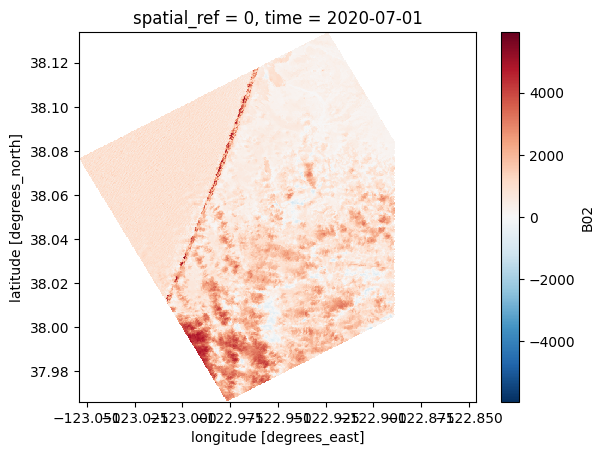

In [10]:
# open all raster files and concatenate

da = ds[bands[0]]
da.isel({"time":0}).plot()